In [1]:
# Example performance of mena recalibration:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys


[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from plotting_utils import figSize
from lineplots import plotsd
from session_utils import *
from recalibration_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



data_dir    = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/'
fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'
participant = 'T5/historical/'
min_nblocks = 3

# preprocess by selecting sessions with a minimal block count:
files  = loadDataset(data_dir, participant)
files  = get_Sessions(files, min_nblocks = 3)

### **Train linear regression on day 0, get baseline performance measure**

Let's measure performance with two approaches - training (and testing) using overall mean estimates versus taking into account session variance. 

For latter strategy, we subtract within-block means prior to training regressor. At test time we update the means on each new block using past block. 

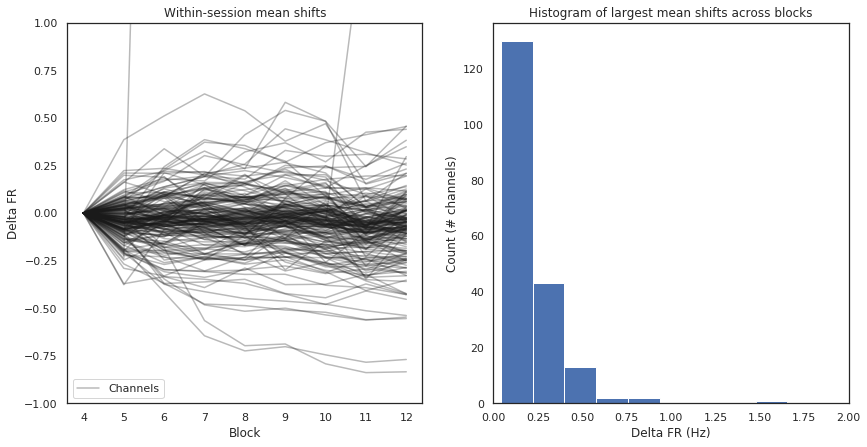

In [100]:
figSize(7, 14)

# Get initial day performance and decoder:
day0       = DataStruct(files[20], alignScreens = True, causal_filter= 2)
date       = 't5.' + day0.date

n_channels = day0.TX[0].shape[1] 
blocks     = np.copy(day0.blockList)
means      = np.zeros((len(blocks), n_channels))

for i, block in enumerate(blocks):
    trls        = np.where(day0.blockNums == block)[0]
    neural      = np.concatenate([day0.TX[j] for j in trls]) 
    means[i, :] = neural.mean(axis = 0)

plt.subplot(1, 2, 1)
_ = plt.plot(blocks, (means - means[0, :]) / means[0, :], color = 'k', alpha = 0.3)
#plt.gca().set_yscale('log')
plt.ylim([-1, 1])
plt.xlabel('Block')
plt.ylabel('Delta FR')
plt.title('Within-session mean shifts')
plt.legend(['Channels'])

plt.subplot(1, 2, 2)
plt.hist(np.max(np.abs((means - means[0, :]) / means[0, :]), axis = 0), bins = 40)
plt.xlim([0, 2])
plt.xlabel('Delta FR (Hz)')
plt.ylabel('Count (# channels)')
plt.title('Histogram of largest mean shifts across blocks')

plt.savefig(fig_path + 'means/exampleshift_session', format = 'pdf')
plt.show()

Holdout performance (naive mean recal): R^2 =  0.06009620169949973
Holdout performance (within-block mean recal): R^2 =  0.4412736419235652


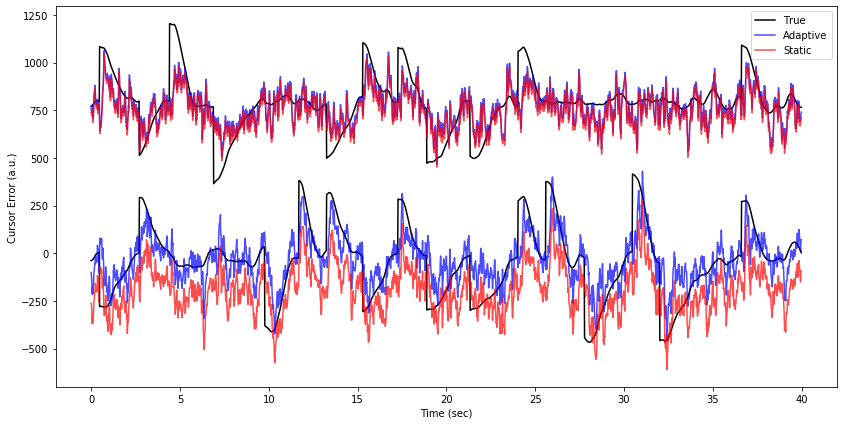

In [3]:
task       = None
blocks     = day0.blockList


train_blocks, test_blocks = train_test_split(np.arange(len(blocks)), test_size = 0.33, shuffle = False)
means      = np.zeros((len(blocks), n_channels))
x, y       = list(), list()

for i, block in enumerate(blocks):
    trls        = np.where(day0.blockNums == block)[0]
    neural      = np.concatenate([day0.TX[j].astype('float') for j in trls]) 
    cursorErr   = np.concatenate([day0.targetPos[j] - day0.cursorPos[j] for j in trls])
    
    means[i, :] = neural.mean(axis = 0)
    x.append(neural)
    y.append(cursorErr)
    
train_x         = np.concatenate([x[i] for i in train_blocks])
train_x_withinB = np.concatenate([x[i] - x[i].mean(axis = 0) for i in train_blocks])
test_x          = np.concatenate([x[i] for i in test_blocks])
test_x_withinB  = np.concatenate([x[i] - x[i-1].mean(axis = 0) for i in test_blocks])

train_x -= train_x.mean(axis = 0)
test_x  -= train_x.mean(axis = 0)
train_y  = np.concatenate([y[i] for i in train_blocks])
test_y   = np.concatenate([y[i] for i in test_blocks])

#-----------------------------------------------------

ref_decoder = LinearRegression().fit(train_x, train_y)
ref_scores  = ref_decoder.score(test_x, test_y)
print('Holdout performance (naive mean recal): R^2 = ', np.mean(ref_scores))
new_decoder = LinearRegression(normalize = False).fit(train_x_withinB, train_y)
new_scores  = new_decoder.score(test_x_withinB, test_y)
print('Holdout performance (within-block mean recal): R^2 = ', np.mean(new_scores))

times  = np.arange(6000, 8000) 
colors = ['red', 'blue'] 

for i in range(2):
    plt.plot((times - times[0]) / 50, test_y[times, i] + (i * 800), color = 'k')
    plt.plot((times - times[0]) / 50, new_decoder.predict(test_x_withinB[times, :])[:, i] + (i * 800), linestyle = '-', color = 'blue', alpha = 0.7)
    plt.plot((times - times[0]) / 50, ref_decoder.predict(test_x[times, :])[:, i] + (i * 800), linestyle = '-', color = 'red', alpha = 0.7)
plt.legend(['True', 'Adaptive', 'Static'])
plt.xlabel('Time (sec)')
plt.ylabel('Cursor Error (a.u.)')


plt.savefig(fig_path + 'means/exampleshift_decoded_session', format = 'pdf')
plt.show()

Now look across all sessions:

In [25]:
from recalibration_utils import get_BlockwiseMeanSubtracted

n_channels = 192
task       = None
sigma      = 2

scores = np.zeros((len(files), 2))
for i, f in enumerate(files):
    session    = DataStruct(f, causal_filter= sigma, alignScreens = True)
    date       = 't5.' + session.date
    blocks     = None
        
    x, y           = list(), list()
    xa, xb, ya, yb = getTrainTest(session, train_size = 0.67, task = task, blocks = blocks, shuffle = False, returnFlattened = True)
    
    # overall mean subtraction:
    train_x         = np.concatenate(xa)
    test_x          = np.concatenate(xb)
    train_x        -= train_x.mean(axis = 0)
    test_x         -= train_x.mean(axis = 0)
    
    # adaptive/within-block approach:
    train_x_withinB, test_x_withinB = get_BlockwiseMeanSubtracted(xa, xb, concatenate = True)
    
    train_y         = np.concatenate(ya)
    test_y          = np.concatenate(yb)
    scores[i, 0]    = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y])[0][0]
    scores[i, 1]    = traintest_DecoderSupervised([train_x_withinB], [test_x_withinB], [train_y], [test_y])[0][0]
    
    if (i + 1) % 10 == 0:
        print(i+1, '/', len(files))

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


10 / 61
20 / 61
30 / 61
40 / 61
50 / 61
60 / 61


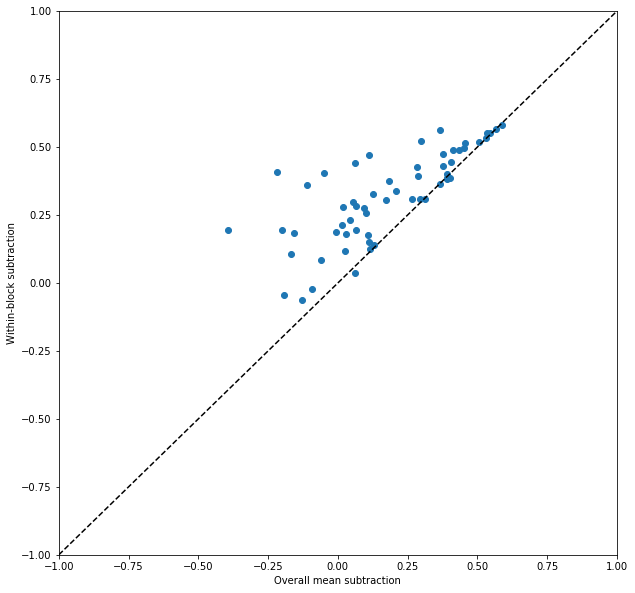

In [26]:
figSize(5, 5)
from lineplots import comparisonScatterPlot

comparisonScatterPlot(scores[:, 0], scores[:, 1], xy_lims = [-1, 1])
plt.xlabel('Overall mean subtraction')
plt.ylabel('Within-block subtraction')

plt.savefig(fig_path + 'means/exampleshift_decoderComparison_all', format = 'pdf')
plt.show()


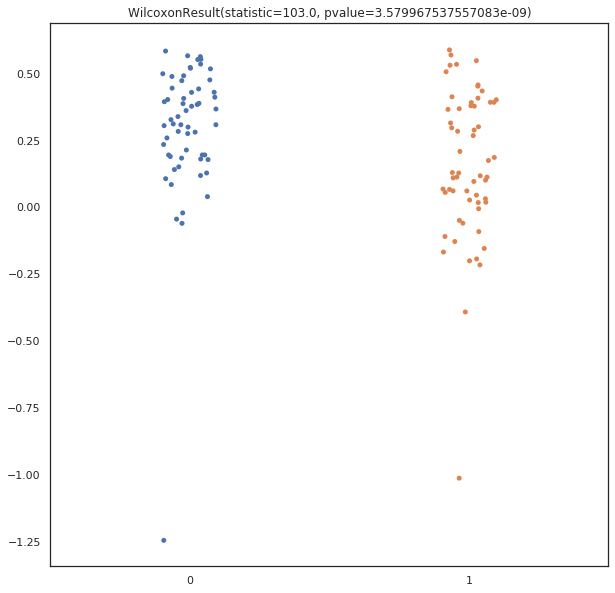

In [78]:
import seaborn as sns

sns.stripplot(data = [scores[:, 1], scores[:, 0]])
#plt.ylim([-1.5, 1])
plt.title(str(scipy.stats.wilcoxon(scores[:, 0], scores[:, 1])))
plt.savefig(fig_path + 'means/exampleshift_decoderComparison_wilcoxon.pdf', format = 'pdf')
plt.show()

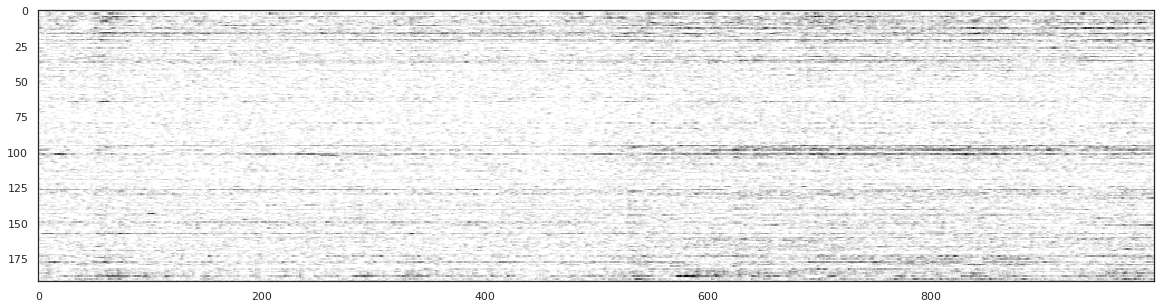

In [120]:
figSize(5, 20)

plt.imshow(day0.TX_continuous[:1000, :].T, aspect = 'auto')
plt.set_cmap('binary')
plt.savefig(fig_path + 'means/example_approaches', format = 'pdf')
plt.show()

Big difference! Main impact seems to be from the adaptive means at test time (rather than better PD estimates during training).